# NLP with Disaster Tweets - USE

# Exploratory Data Analysis 

####  Imports

In [1]:
pip install pandarallel

  Preparing metadata (setup.py) ... - \ done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16693 sha256=b9ca535c8efc9b7688f28b6045bfad04c634d06da3f9a09ceef18ab73b9259a4
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import seaborn as sns

#NLP

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

from wordcloud import WordCloud
from PIL import Image

#import plotly as px
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub


import nlpaug.augmenter.word as naw
nltk.download('wordnet2022')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [4]:
# download

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

#### Load data

In [5]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv", dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


## First tour

In [6]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
tmp = df_train.nunique()
tmp

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [8]:
df_train.isna().mean().sort_values()

id          0.000000
text        0.000000
target      0.000000
keyword     0.008013
location    0.332720
dtype: float64

<AxesSubplot: >

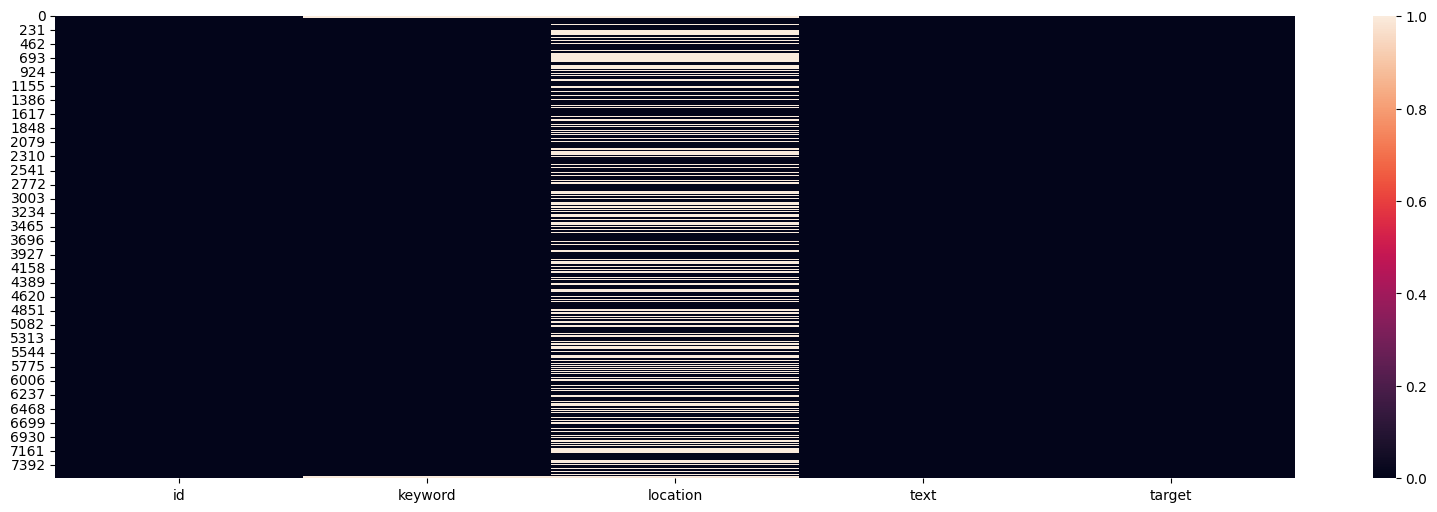

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.heatmap(df_train.isna())

In [10]:
df_train.duplicated().sum()

0

In [11]:
df_train.duplicated(subset="text").sum()

110

In [12]:
for col in df_train.columns :
    n = df_train.duplicated(subset=col).sum()
    print(f"col: {col} -> duplicated: {n}")

col: id -> duplicated: 0
col: keyword -> duplicated: 7391
col: location -> duplicated: 4271
col: text -> duplicated: 110
col: target -> duplicated: 7611


In [13]:
idx = df_train.duplicated(subset="text", keep="first")
df_train.loc[idx, :].sort_values("text")

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1


In [14]:
df_train.describe(include=np.number)

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [15]:
df_train.describe(include=object)

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [16]:
tmp = df_train.dtypes
tmp

id           int16
keyword     object
location    object
text        object
target        int8
dtype: object

In [17]:
cols = ["text", "target"]
df = df_train[cols]
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
df.isna().mean()

text      0.0
target    0.0
dtype: float64

In [19]:
idx = df.duplicated(subset="text", keep="first")
df.loc[idx, :].sort_values("text")

,text,target
4299,#Allah describes piling up #wealth thinking it...,0
4312,#Allah describes piling up #wealth thinking it...,1
6366,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...
3461,that exploded &amp; brought about the\nbeginni...,0
6103,that horrible sinking feeling when youÛªve be...,0
6094,that horrible sinking feeling when youÛªve be...,0
6123,that horrible sinking feeling when youÛªve be...,1


In [20]:
df.drop_duplicates(subset="text", inplace=True)

/tmp/ipykernel_24/2880993212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset="text", inplace=True)


## Exploratory Data Analysis

### Target

In [21]:
df.describe()

,target
count,7503.000000
mean,0.426230
std,0.494561
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [22]:
df.target.value_counts()

0    4305
1    3198
Name: target, dtype: int64

In [23]:
df.target.value_counts(normalize=True)

0    0.57377
1    0.42623
Name: target, dtype: float64

<AxesSubplot: ylabel='target'>

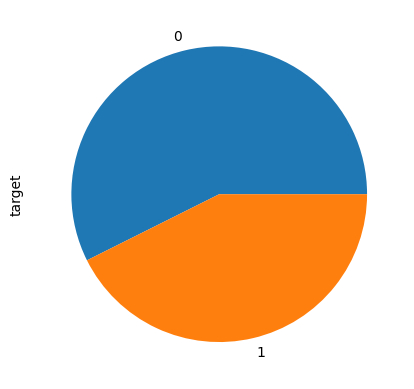

In [24]:
df.target.value_counts().plot(kind="pie")

### Lenght

In [25]:
df.describe(include="object")

,text
count,7503
unique,7503
top,Our Deeds are the Reason of this #earthquake M...
freq,1


In [26]:
df.text.apply(lambda i : len(i))

0        69
1        38
2       133
3        65
4        88
       ... 
7604    136
7605    114
7606    121
7608     83
7612     94
Name: text, Length: 7503, dtype: int64

In [27]:
df.text.apply(lambda i : len(i))

0        69
1        38
2       133
3        65
4        88
       ... 
7604    136
7605    114
7606    121
7608     83
7612     94
Name: text, Length: 7503, dtype: int64

<AxesSubplot: >

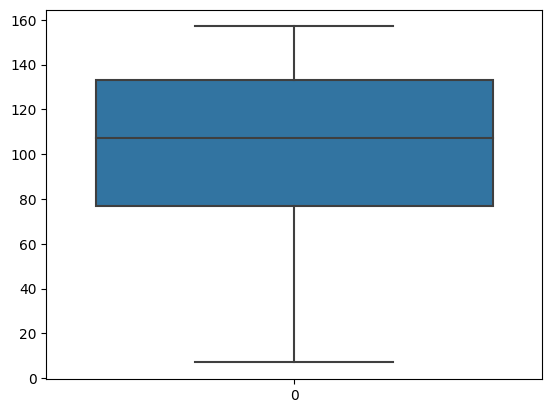

In [28]:
tmp = df.text.str.len()
sns.boxplot(tmp)

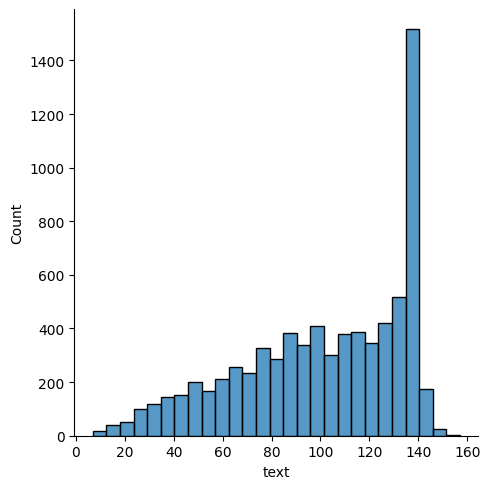

In [29]:
sns.displot(tmp)

In [30]:
df["_len_txt"] = tmp

/tmp/ipykernel_24/3091308944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["_len_txt"] = tmp


### Multivariate analysis

In [31]:
corr = df.corr()
corr

/tmp/ipykernel_24/2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,target,_len_txt
target,1.000000,0.180997
_len_txt,0.180997,1.000000


<AxesSubplot: >

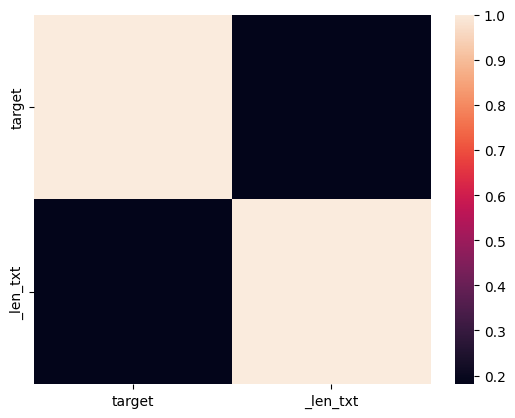

In [32]:
sns.heatmap(corr)

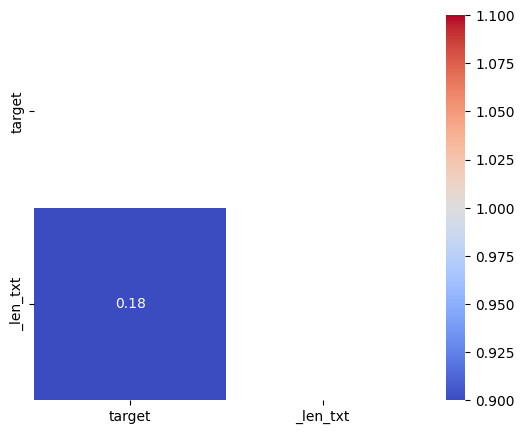

In [33]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax = sns.heatmap(corr, mask=mask, vmin=1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", square=True)

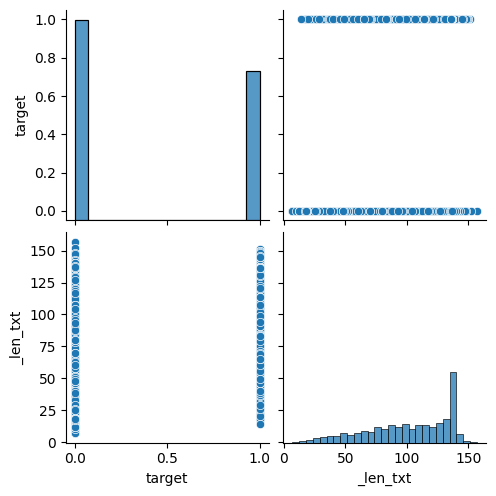

In [34]:
sns.pairplot(df)

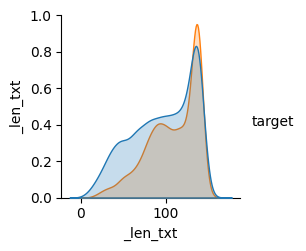

In [35]:
sns.pairplot(df, hue="target")

In [36]:
df.sort_values("_len_txt").head(10)

,text,target,_len_txt
4890,Bad day,0,7
5115,Err:509,0,7
1882,Crushed,0,7
4971,Meltdown,0,8
24,LOOOOOOL,0,8
3670,fatality,0,8
30,The end!,0,8
28,Cooool :),0,9
3667,Fatality!,0,9
6705,Thunder???,0,10


In [37]:
df.sort_values("_len_txt").tail(10)

,text,target,_len_txt
261,@Barbi_Twins We need help-horses will die! Ple...,0,148
2301,Nah but srsly b4 u demolish ur partner's face ...,0,148
6945,@helene_yancey GodsLove &amp; #thankU my siste...,1,148
257,@willienelson We need help! Horses will die!Pl...,1,148
2718,@UN No more #GujaratRiot &amp; #MumbaiRiot92-9...,1,149
635,@cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...,1,150
633,@HowardU If 90BLKs&amp;8WHTs colluded 2 take W...,1,150
614,@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...,1,151
4801,It's was about 2:30 in the morning&amp;I went ...,0,152
1270,when you're taking a shower and someone flushe...,0,157


In [38]:
df.drop(columns="_len_txt", inplace=True)
df.head()

/tmp/ipykernel_24/3619034452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="_len_txt", inplace=True)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### Explore corpus and documents

#### print N random documents

In [39]:
df_samp = df.sample(5)

In [40]:
for idx, ser in df_samp.iterrows():
    txt_1 = f"target : {ser['target']}\n"
    
    print(txt_1 + ser["text"]+ "..." + "\n\n")

target : 0
And last year it was just a lot of 'THE DRUMS ARE FLOODING' and 'JANICE I'M FALLING'...


target : 1
The sunset looked like an erupting volcano .... My initial thought was the Pixar short Lava http://t.co/g4sChqFEsT...


target : 0
No snowflake in an avalanche ever feels responsible....


target : 0
@ABCNews24 @PeterDutton_MP 
He also told you....No-one has drowned in the last 2 years &amp; 1200 had under Labor. But let's not mention that.....


target : 0
Retweeted Sarah Silverman (@SarahKSilverman):

Soundtrack of my walk starts w Tracey Ullman They Don't Know.  perfect...




### Print documents vs target

In [41]:
def print_sample(sub_df, n_samp=5):
    
    """print out n_sample document from a corpus"""
    
    samp = sub_df.sample(n_samp)
    
    for idx, ser in df_samp.iterrows():
        txt_1 = f"target : {ser['target']}\n"
        
        print(txt_1 + ser["text"]+ "..." + "\n\n")

In [42]:
df_1 = df[df.target ==1]
df_1.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [43]:
print_sample(df_1)

target : 0
And last year it was just a lot of 'THE DRUMS ARE FLOODING' and 'JANICE I'M FALLING'...


target : 1
The sunset looked like an erupting volcano .... My initial thought was the Pixar short Lava http://t.co/g4sChqFEsT...


target : 0
No snowflake in an avalanche ever feels responsible....


target : 0
@ABCNews24 @PeterDutton_MP 
He also told you....No-one has drowned in the last 2 years &amp; 1200 had under Labor. But let's not mention that.....


target : 0
Retweeted Sarah Silverman (@SarahKSilverman):

Soundtrack of my walk starts w Tracey Ullman They Don't Know.  perfect...




# Text processing

## Preliminary

### Download and options

In [44]:
#pandarallel
pandarallel.initialize(progress_bar=True,
                      nb_workers=6,
                      verbose=1)

In [45]:
#stop_words

stop_words = set(stopwords.words("english"))
print(stop_words)

{'while', 'myself', 'those', 'wasn', 'as', 'because', 'haven', "don't", 'y', "shan't", 'during', 'had', 'yours', 'they', 'don', 'theirs', 'having', 'from', 'just', "hadn't", 'other', 'his', "that'll", 'ain', 'you', "shouldn't", 'weren', 'o', 'doesn', "won't", 'into', "isn't", 'its', 'themselves', 'were', 'by', 'very', 'mustn', 'down', 'will', "weren't", 'and', 'me', 'has', "needn't", 't', 'with', 's', 'so', 'shouldn', 'but', 'he', 'him', "you're", 'shan', 'after', 'ours', 'if', 'this', 'not', 'itself', 'have', "doesn't", 'your', 'hadn', 'their', 'through', 'she', "mightn't", 'over', 'these', 'yourselves', "it's", "you've", 'further', 'couldn', 'when', 'at', "you'll", 'or', 'hasn', "wouldn't", 'same', 'can', 'did', 'of', 'an', 'too', 've', 'is', 'herself', 'a', "she's", 'against', 'again', 'aren', 'between', 'who', 'there', 'nor', 'then', 'what', 'only', 'won', "didn't", 'our', 'any', 'does', 'below', 'than', 'do', 'whom', 'doing', 'my', 'to', 'are', 'the', 'wouldn', 'few', "aren't", 'b

### Build raw corpus

In [46]:
# join all corpus

raw_corpus = "".join(df.text.values)
raw_corpus[:1000]

"Our Deeds are the Reason of this #earthquake May ALLAH Forgive us allForest fire near La Ronge Sask. CanadaAll residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected13,000 people receive #wildfires evacuation orders in California Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areasI'm on top of the hill and I can see a fire in the woods...There's an emergency evacuation happening now in the building across the streetI'm afraid that the tornado is coming to our area...Three people died from the heat wave so farHaha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding#raining #flooding #Florida #TampaBay #

In [47]:
len(raw_corpus)

756907

In [48]:
def process_text_1(doc, rejoin=False) :
    """basis function of tecxt processing"""
    
    #lower
    doc = doc.lower().strip()
    
    #tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    #stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    
    if rejoin :
        return "".join(cleaned_tokens_list)
    
    return cleaned_tokens_list

In [49]:
def display_tokens_info(tokens):
    """display info about corpus"""
    
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

In [50]:
# process the corpus

corpus = process_text_1(raw_corpus)
display_tokens_info(corpus)

nb tokens 82574, nb tokens uniques 22438
['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us', 'allforest', 'fire', 'near', 'la', 'ronge', 'sask', 'canadaall', 'residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected13', '000', 'people', 'receive', 'wildfires', 'evacuation']


In [51]:
# values counts

tmp = pd.Series(corpus).value_counts()
tmp

co                  4703
http                4231
https                405
amp                  342
like                 341
                    ... 
destructiontruck       1
salvages               1
7b2wf6ovfk             1
newsrepublican         1
ymy4rskq3d             1
Length: 22438, dtype: int64

In [52]:
tmp.describe()

count    22438.000000
mean         3.680096
std         43.379216
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       4703.000000
dtype: float64

In [53]:
#unique words --> note useful

tmp = pd.Series(corpus).value_counts()
list_unique_words = tmp[tmp==1]
list_unique_words[:30]

dub                   1
mxhrextrkh            1
ctijdpxabkdogs        1
splatling             1
foothill              1
designsso             1
thatrussianman        1
waterboarding         1
writingtips           1
salmanmydarling       1
ps3                   1
xboxhttps             1
qr1l2jyuez            1
nester                1
switching             1
dipping               1
pantherattackthere    1
dieanpink95           1
limitsabe             1
yu_nita99             1
sivan                 1
pantherattacki        1
camilla_33            1
uooygbb6az            1
akq4rwjfvlcheck       1
skippy6gaming         1
slttorrlhswho         1
craykain              1
lavalet               1
basalt                1
dtype: int64

In [54]:
print(len(list_unique_words))
list_unique_words = list(list_unique_words.index)

16230


In [55]:
#idem for min 5 times

tmp = pd.Series(corpus).value_counts()
list_min_5_words = tmp[tmp < 5]
#save it
list_min_5_words = list(list_min_5_words)
#display first 30
list_min_5_words[:30]

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [56]:
#idem for min 10 times

tmp = pd.Series(corpus).value_counts()
list_min_10_words = tmp[tmp < 10]

#save it

list_min_10_words = list(list_min_10_words)

list_min_10_words[:30]

[9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9]

In [57]:
def process_text(doc,
                   rejoin=False,
                   lemm_or_stemm="stem",
                  list_rare_words=None,
                  min_len_word=3,
                  force_is_alpha=True,
                  eng_words=None,
                  extra_words=None) :
    
    
    """cf process_text_1 but with list_unique_words, min_len_word and force_is_alpha
    
    positional arguments:
    ---------------------
    doc : str : the document (aka a text in str format) to process
    
    opt args:
    -----------------------------
    rejoin : bool : if True return a string else return the list of tokens
    lemm_or_stemm : str : if lem do lemmentize else stemmentize
    list_rare_words : list : a liste of rare words to exclude
    min_len_word : int : the minimum lenght of words to not exclude
    force_is_alpha : int : if 1, exclude all tokens with numeric character
    eng_words: list : list of english words
    extra_words: list : list of extra word
    
    return : 
    ------------------
    a string (if rejoin is True) or a list of tokens
    
    """
    
    # list_unique_words
    if not list_rare_words:
        list_rare_words = []
        
    #lower
    doc = doc.lower().strip()
    
    #tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    #stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    
    ############################################################################
    ############################################################################
    
    #no rare tokens
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    
    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]
    
    #only alpha chars
    if force_is_alpha : 
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N
    
    #############################################################################
    #############################################################################
    
    #stem or lem
    
    if lemm_or_stemm=="lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else:
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
    
    #############################################################################
    #################################################################################
    
    # in english
    if eng_words :
        engl_text = [i for i in trans_text if i in eng_words]
    else:
        engl_text = trans_text
    
    ###############################################################################
    ###############################################################################
    
    # drop extra words tokens
    if extra_words :
        final = [w for w in engl_text if w not in extra_words ]
    else:
        final = [w for w in engl_text] 
        
    ################################################################################
    ###############################################################################
    # manage return type
    if rejoin :
        return " ".join(final)
    
    return final

In [58]:
eng_words = [i.lower() for i in words.words()]
eng_words[:30]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron',
 'aaronic',
 'aaronical',
 'aaronite',
 'aaronitic',
 'aaru',
 'ab',
 'aba',
 'ababdeh',
 'ababua',
 'abac',
 'abaca',
 'abacate',
 'abacay',
 'abacinate',
 'abacination',
 'abaciscus',
 'abacist',
 'aback',
 'abactinal',
 'abactinally']

In [59]:
ps = PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

nb tokens 236736, nb tokens uniques 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


In [60]:
def final_clean(doc):
    
    """perform our final cleaning"""
    
    new_doc = process_text(doc,
                             rejoin=True, 
                             lemm_or_stemm="stem",
                             list_rare_words=list_min_5_words,
                             eng_words=eng_words_stem,
                            extra_words=None)
    return new_doc

In [61]:
#df["clean_text"] = df.text.apply(final_clean)

df["clean_text"] = df.text.parallel_apply(final_clean)

/tmp/ipykernel_24/858156653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_text"] = df.text.parallel_apply(final_clean)


In [62]:
test_df = df_test.copy()
test_df["preprocesstext"]= df_test.text.parallel_apply(final_clean)
test_df = test_df["preprocesstext"]

## Data augmentation

In [63]:

def augment_dataframe(df):
    """Augment text data using synonym replacement with NLPAug.

    Args:
        df (pd.DataFrame): Original dataframe with text data to be augmented.

    Returns:
        pd.DataFrame: Augmented dataframe with the same columns as the original.

    """
    # Initialize augmenter
    aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.1)

    # Create new dataframe to store augmented data
    df_aug = pd.DataFrame(columns=['text', 'target'])

    # Loop through rows of original dataframe
    for i, row in df.iterrows():
        # Augment text and add to new dataframe
        text_aug = aug.augment(row['text'])
        df_aug = pd.concat(
            [df_aug, pd.DataFrame({'text': text_aug, 'target': row['target']}, index=[0])],
            ignore_index=True
        )

    # Concatenate original and augmented dataframes
    df_concat = pd.concat([df, df_aug], ignore_index=True)

    return df_concat

In [64]:
data = df[["text", "target"]]
df_augmented = augment_dataframe(data)
df_augmented

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
15001,# WorldNews Fallen powerlines on G: link tram:...,1
15002,on the flip side 1 ' m at Walmart and there is...,1
15003,Suicide cuban sandwich kills 15 in Saudi secur...,1
15004,Ii giant cranes holding a bridge collapse into...,1


In [65]:
#df["clean_text"] = df.text.apply(final_clean)

df_augmented["clean_text"] = df_augmented.text.parallel_apply(final_clean)

In [66]:
df_augmented.shape

(15006, 3)

In [67]:
X_aug = df_augmented["clean_text"]
Y_aug = df_augmented['target']
# Split into training and testing sets
X_train_aug, x_test_aug, Y_train_aug, y_test_aug = train_test_split(X_aug, Y_aug,
                                                                    test_size=0.2, random_state=42)

# Split the training set into training and validation sets
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(X_train_aug, Y_train_aug, 
                                                                  test_size=0.25, random_state=42)

# Print the shapes of the resulting datasets
print("Shape of training set:", x_train_aug.shape)
print("Shape of validation set:", x_val_aug.shape)
print("Shape of testing set:", x_test_aug.shape)

Shape of training set: (9003,)
Shape of validation set: (3001,)
Shape of testing set: (3002,)


# Universal Sentence Encoder Classification

## Data splitting

In [68]:
X = df["clean_text"]
Y = df['target']
# Split into training and testing sets
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

# Print the shapes of the resulting datasets
print("Shape of training set:", x_train.shape)
print("Shape of validation set:", x_val.shape)
print("Shape of testing set:", x_test.shape)

Shape of training set: (4501,)
Shape of validation set: (1501,)
Shape of testing set: (1501,)


# Model Building and Training

In [69]:

def build_use_model():
    # Load Universal Sentence Encoder
    use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    # Create model architecture
    input_layer = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")
    embedding_layer = tf.keras.layers.Lambda(use_embed, output_shape=(512,))(input_layer)
    output_layer = tf.keras.layers.Dense(2, activation="sigmoid")(embedding_layer)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [70]:
# Encode labels for binary classification
y_train_encoded =  tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val_encoded =  tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test_encoded =  tf.keras.utils.to_categorical(y_test, num_classes=2)

# Build model
model = build_use_model()

# Train model
history = model.fit(x_train, y_train_encoded, epochs=60, validation_data=(x_val, y_val_encoded))

Epoch 1/60
141/141 [==============================] - 10s 16ms/step - loss: 0.6737 - accuracy: 0.6427 - val_loss: 0.6520 - val_accuracy: 0.7069
Epoch 2/60
141/141 [==============================] - 2s 13ms/step - loss: 0.6384 - accuracy: 0.7147 - val_loss: 0.6213 - val_accuracy: 0.7382
Epoch 3/60
141/141 [==============================] - 2s 13ms/step - loss: 0.6117 - accuracy: 0.7492 - val_loss: 0.5976 - val_accuracy: 0.7588
Epoch 4/60
141/141 [==============================] - 3s 20ms/step - loss: 0.5908 - accuracy: 0.7578 - val_loss: 0.5790 - val_accuracy: 0.7662
Epoch 5/60
141/141 [==============================] - 2s 13ms/step - loss: 0.5741 - accuracy: 0.7632 - val_loss: 0.5643 - val_accuracy: 0.7715
Epoch 6/60
141/141 [==============================] - 2s 13ms/step - loss: 0.5605 - accuracy: 0.7692 - val_loss: 0.5521 - val_accuracy: 0.7775
Epoch 7/60
141/141 [==============================] - 2s 14ms/step - loss: 0.5495 - accuracy: 0.7714 - val_loss: 0.5424 - val_accuracy: 0.776

In [71]:
def plot_history(history):
    """
    Plots the training and validation accuracy and loss over epochs.

    Parameters:
    history (keras.callbacks.History): The history object returned by model.fit().

    Returns:
    None
    """
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


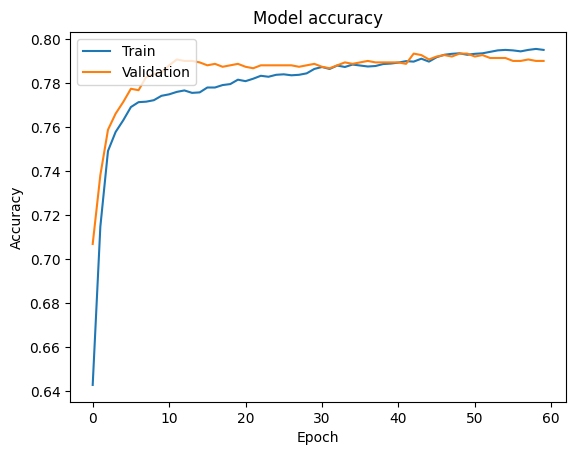

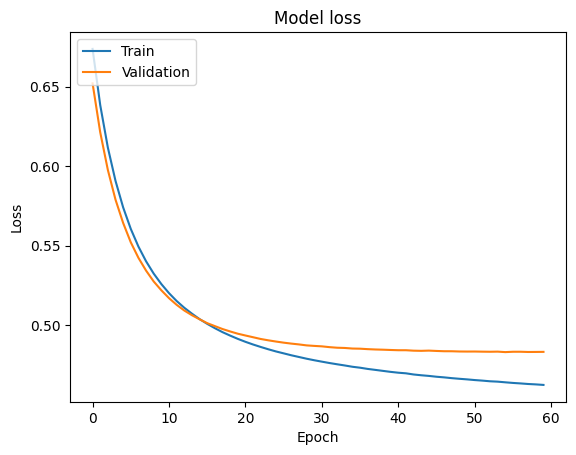

In [72]:
plot_history(history)

In [73]:
y_test_encoded =  tf.keras.utils.to_categorical(y_test, num_classes=2)
#X_test_trans = use_embed(x_test)
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

47/47 [==============================] - 0s 9ms/step - loss: 0.5203 - accuracy: 0.7575
Test loss: 0.5202904343605042
Test accuracy: 0.7574949860572815


In [74]:
# Encode labels for binary classification
y_train_encoded_aug =  tf.keras.utils.to_categorical(y_train_aug, num_classes=2)
y_val_encoded_aug =  tf.keras.utils.to_categorical(y_val_aug, num_classes=2)
y_test_encoded_aug =  tf.keras.utils.to_categorical(y_test_aug, num_classes=2)


# Build model
model_aug = build_use_model()

# Train model
history_aug = model_aug.fit(x_train_aug, y_train_encoded_aug, epochs=60, validation_data=(x_val_aug, y_val_encoded_aug))

Epoch 1/60
282/282 [==============================] - 8s 14ms/step - loss: 0.6600 - accuracy: 0.6764 - val_loss: 0.6275 - val_accuracy: 0.7244
Epoch 2/60
282/282 [==============================] - 4s 13ms/step - loss: 0.6111 - accuracy: 0.7360 - val_loss: 0.5897 - val_accuracy: 0.7438
Epoch 3/60
282/282 [==============================] - 4s 15ms/step - loss: 0.5810 - accuracy: 0.7475 - val_loss: 0.5660 - val_accuracy: 0.7581
Epoch 4/60
282/282 [==============================] - 4s 13ms/step - loss: 0.5608 - accuracy: 0.7573 - val_loss: 0.5502 - val_accuracy: 0.7631
Epoch 5/60
282/282 [==============================] - 4s 13ms/step - loss: 0.5466 - accuracy: 0.7600 - val_loss: 0.5389 - val_accuracy: 0.7661
Epoch 6/60
282/282 [==============================] - 4s 13ms/step - loss: 0.5361 - accuracy: 0.7597 - val_loss: 0.5308 - val_accuracy: 0.7711
Epoch 7/60
282/282 [==============================] - 4s 13ms/step - loss: 0.5280 - accuracy: 0.7631 - val_loss: 0.5248 - val_accuracy: 0.7747

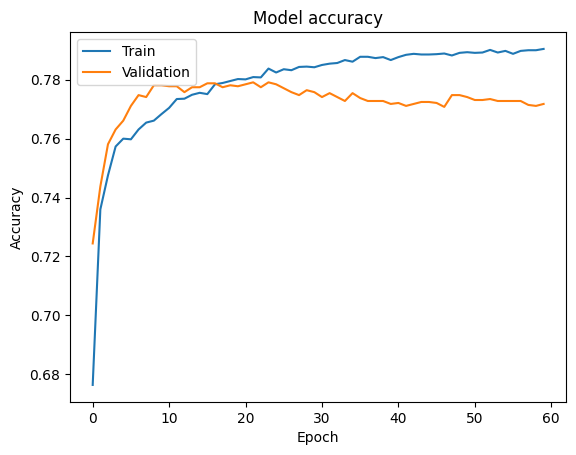

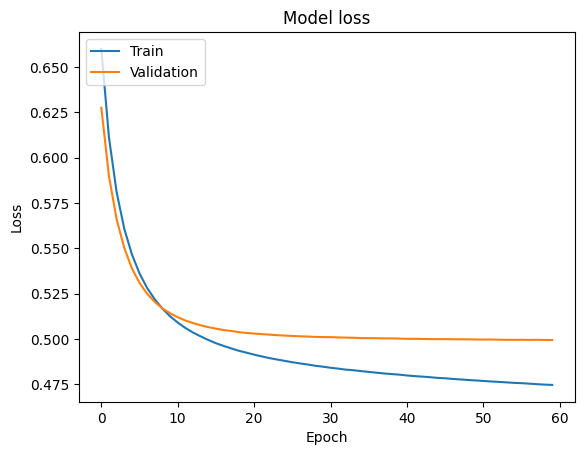

In [75]:
plot_history(history_aug)

## Model Evaluation and submission

In [76]:
#X_test_trans = use_embed(x_test)
loss, accuracy = model_aug.evaluate(x_test_aug, y_test_encoded_aug)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

94/94 [==============================] - 1s 9ms/step - loss: 0.4976 - accuracy: 0.7655
Test loss: 0.49759161472320557
Test accuracy: 0.7654896974563599


In [77]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
# Predict classes for test set
y_pred = model_aug.predict(test_df)

# Convert predicted probabilities to class labels
submission["target"] = np.argmax(y_pred, axis=1)
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 10ms/step
